In [2]:
! wget https://worksheets.codalab.org/rest/bundles/0x550cd344825049bdbb865b887381823c/contents/blob/dataset_dog-fish_train-900_test-300.npz

--2023-12-15 15:41:54--  https://worksheets.codalab.org/rest/bundles/0x550cd344825049bdbb865b887381823c/contents/blob/dataset_dog-fish_train-900_test-300.npz
Resolving worksheets.codalab.org (worksheets.codalab.org)... 20.232.203.197
Connecting to worksheets.codalab.org (worksheets.codalab.org)|20.232.203.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [text/plain]
Saving to: ‘dataset_dog-fish_train-900_test-300.npz’

dataset_dog-fish_tr     [              <=>   ] 679.68M  13.9MB/s    in 52s     

2023-12-15 15:42:47 (13.2 MB/s) - ‘dataset_dog-fish_train-900_test-300.npz’ saved [712701930]



In [3]:
! pip install git+https://github.com/alstonlo/torch-influence.git

  Cloning https://github.com/alstonlo/torch-influence.git to /tmp/pip-req-build-jmnxcotd
  Running command git clone --filter=blob:none --quiet https://github.com/alstonlo/torch-influence.git /tmp/pip-req-build-jmnxcotd
  Resolved https://github.com/alstonlo/torch-influence.git to commit 8b4f0756acf642a38a8b24a517da89343a9de7d0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-influence: filename=torch_influence-0.1.0-py3-none-any.whl size=14681 sha256=48e88060e30d2a29c73d4aed9eb67c3d4c0d432dfb09635e92969658cec592c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-rn5r9bi0/wheels/48/dc/b3/0fd624ebc8e58bdc1648b0538d4db2c0a2f81fc8ee71db04b0
Successfully built torch-influence


In [6]:
import pathlib

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from sklearn import linear_model
from torch import nn
from torch.utils import data
from tqdm import tqdm, trange
import os
from torch_influence import BaseObjective, CGInfluenceModule


# Example-specific constants
BASE_DIR = '.'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DOGFISH_RAW_PATH = BASE_DIR + "/dataset_dog-fish_train-900_test-300.npz"
DOGFISH_EMB_PATH = BASE_DIR + "/dataset_dog-fish_embeds.npz"

DOGFISH_RAW_MMAP = np.load(str(DOGFISH_RAW_PATH), mmap_mode="r")

L2_WEIGHT = 1e-4


def load_dogfish_examples(split, idxs):
    image = DOGFISH_RAW_MMAP[f"X_{split}"][idxs]
    label = DOGFISH_RAW_MMAP[f"Y_{split}"][idxs]
    return image, label


def load_inception_embeds():
    if os.path.exists(DOGFISH_EMB_PATH):
        print(f"Using cached Inceptionv3 embeddings: {DOGFISH_EMB_PATH}")
        return np.load(str(DOGFISH_EMB_PATH))

    # load pretrained Inceptionv3
    model = torchvision.models.inception_v3(pretrained=True, transform_input=False)
    model.fc = nn.Identity()  # remove the last layer
    model.eval()
    model = model.to(DEVICE)

    embeds = {}
    BATCH_SIZE = 60
    for split in ("train", "test"):
        n = 2 * (900 if (split == "train") else 300)

        X, Y = [], []
        for idx in trange(0, n, BATCH_SIZE, desc=f"Embedding Dogfish ({split})"):
            batch_idxs = [idx + offset for offset in range(BATCH_SIZE)]
            images, labels = load_dogfish_examples(split, batch_idxs)

            # getting Inceptionv3 embedding
            with torch.no_grad():
                images = torch.tensor(images, dtype=torch.float32, device=DEVICE)
                images = images.permute([0, 3, 1, 2])
                h = model(images).cpu().numpy()

            X.append(h)
            Y.append(labels)

        embeds[f"X_{split}"] = np.concatenate(X, axis=0).astype(np.float32)
        embeds[f"Y_{split}"] = np.concatenate(Y, axis=0).astype(np.float32)

    np.savez(str(DOGFISH_EMB_PATH), **embeds)
    return embeds




def captioned_image(model, embeds, split, idx, scores):
    x = embeds[f"X_{split}"][idx]
    y = embeds[f"Y_{split}"][idx].item()

    x = torch.tensor(x, device=DEVICE).unsqueeze(0)
    y_hat = model(x).round().item()

    # turn image into [0 .. 255] RGB image
    image, _ = load_dogfish_examples(split, idx)
    image = (image * 127.5) + 127.5
    image = image.clip(min=0.0, max=255.0)
    image = np.round(image).astype(np.uint8)

    # turn labels into human-readable strings
    class_names = ["dog", "fish"]
    label = class_names[int(y)]
    pred = class_names[int(y_hat)]

    if split == "test":
        score_caption = f"Test Loss: {scores[idx]:.5f}"
    else:
        score_caption = f"Influence: {scores[idx]:+.5f}"
    label_caption = f"Pred: {pred}, Label: {label}"
    return image, label_caption + "\n" + score_caption


print(f"Using {DEVICE}")

# ===========
# Load model and data
# ==========

embeds = load_inception_embeds()

X_train = torch.tensor(embeds["X_train"])
Y_train = torch.tensor(embeds["Y_train"])
train_set = data.TensorDataset(X_train, Y_train)

X_test = torch.tensor(embeds["X_test"])
Y_test = torch.tensor(embeds["Y_test"])
test_set = data.TensorDataset(X_test, Y_test)



Using cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Embedding Dogfish (test): 100%|██████████| 10/10 [00:43<00:00,  4.34s/it]


In [7]:
def fit_model(X, Y):
    C = 1 / (X.shape[0] * L2_WEIGHT)
    sk_clf = linear_model.LogisticRegression(C=C, tol=1e-8, max_iter=1000)
    sk_clf = sk_clf.fit(X.numpy(), Y.numpy())

    # recreate model in PyTorch
    fc = nn.Linear(2048, 1, bias=True)
    print(sk_clf.coef_, sk_clf.intercept_)
    fc.weight = nn.Parameter(torch.tensor(sk_clf.coef_))
    fc.bias = nn.Parameter(torch.tensor(sk_clf.intercept_))

    pt_clf = nn.Sequential(
        fc,
        nn.Flatten(start_dim=-2),
        nn.Sigmoid()
    )

    pt_clf = pt_clf.to(device=DEVICE, dtype=torch.float32)
    return pt_clf
clf = fit_model(X_train, Y_train)

[[-0.05636463 -0.15297256  0.1011622  ... -0.01073345 -0.16798809
  -0.03196982]] [-1.33386781]


## Base model accuracy on the test set

In [8]:
with torch.no_grad():
    clf = clf.cuda()
    outputs = clf(X_test.cuda())
    predictions = torch.round(outputs).long()

    # Calculate accuracy
    correct = (predictions == Y_test.cuda()).sum().item()
    total = len(Y_test)
    accuracy = correct / total

    # Print the accuracy
    print(f"Accuracy on test set: {accuracy:.4f}")

Accuracy on test set: 0.9867


## Calculate the influences

In [10]:

# ===========
# Get indices of top 3% test images with highest test loss
# ===========

test_losses = F.binary_cross_entropy(clf(X_test.to(DEVICE)), Y_test.to(DEVICE), reduction="none")
test_idxs = torch.argsort(test_losses, dim=0, descending=True)[:int(len(X_train)*0.05)]
test_idxs = test_idxs.tolist()

test_images = [captioned_image(clf, embeds, "test", idx, test_losses) for idx in test_idxs]

# ===========
# Initialize influence module using custom objective
# ===========

class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])

module = CGInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=1000,
)

# ===========
# For each test point:
#   1. Get the influence scores for all training points
#   2. Find the most helpful and harmful training points
# The most helpful point is that which, if removed, most increases the loss at the
# test point of interest (as predicted by the influence scores). Conversely, the most harmful
# test point is that which most decreases the test loss if removed.
# ===========

helpful_images = []
harmful_images = []
helpful_images_idx = set()
harmful_images_idx = set()

all_train_idxs = list(range(X_train.shape[0]))
for test_idx in tqdm(test_idxs, desc="Computing Influences"):
    # In practice, this can be further optimized since we are recomputing the
    # loss gradients over the entire training dataset. With enough space, these
    # gradients can be cached instead.
    influences = module.influences(train_idxs=all_train_idxs, test_idxs=[test_idx])

    helpful = captioned_image(clf, embeds, "train", influences.argmax(), influences)
    harmful = captioned_image(clf, embeds, "train", influences.argmin(), influences)

    helpful_images.append(helpful)
    harmful_images.append(harmful)
    helpful_images_idx.add(influences.argmax())
    harmful_images_idx.add(influences.argmin())

image_grid = [test_images, helpful_images, harmful_images]

Computing Influences: 100%|██████████| 90/90 [46:35<00:00, 31.06s/it]


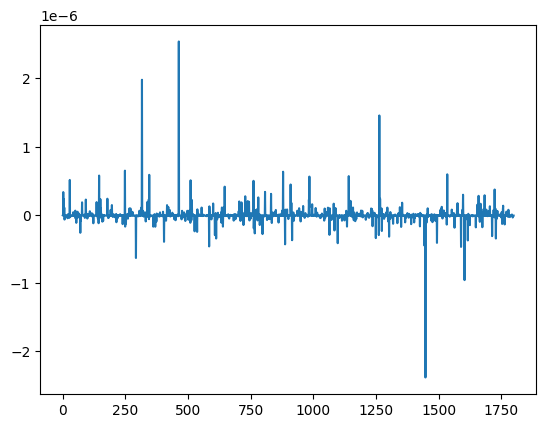

In [11]:
influences = module.influences(train_idxs=all_train_idxs, test_idxs=[0])
plt.plot(influences.numpy())

(array([1.639e+03, 8.100e+01, 3.300e+01, 1.600e+01, 1.000e+01, 7.000e+00,
        5.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([4.83042729e-12, 8.46438653e-08, 1.69282913e-07, 2.53921939e-07,
        3.38560994e-07, 4.23200021e-07, 5.07839047e-07, 5.92478102e-07,
        6.77117157e-07, 7.61756155e-07, 8.46395210e-07, 9.31034265e-07,
        1.01567332e-06, 1.10031237e-06, 1.18495132e-06, 1.26959037e-06,
        1.35422943e-06, 1.43886848e-06, 1.52350754e-06, 1.60814659e-06,
        1.69278553e-06, 1.77742459e-06, 1.86206364e-06, 1.94670270e-06,
        2.03134164e-06, 2.11598081e-06, 2.20061975e-06, 2.28525892e-06,
        2.36989786e-06, 2.45453703e-06, 2.53917597e-06]),
 <BarContainer object of 30 artists>)

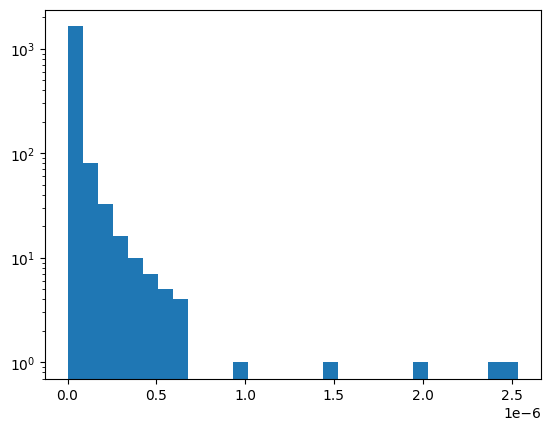

In [12]:
plt.hist(np.absolute(influences), log=True, bins=30)

In [46]:
indexes = [int(idx.item()) for idx in list(helpful_images_idx)]
indexes = list(set(indexes))
indexes.sort()

In [47]:
# remove the most helpful images

def calc_accuracy_drop():
    accuracies = []
    def remove_elements(tensor, indices):
        keep_indices = [i for i in range(len(tensor)) if i not in indices]
        mask = torch.ones(len(tensor), dtype=torch.bool, device=tensor.device)
        mask[keep_indices] = False
        return tensor[~mask]

    for i in range(len(indexes)):
        print(i)
        X_update = remove_elements(X_train, indexes[:i+1])
        Y_update = remove_elements(Y_train, indexes[:i+1])

        clf_adv = fit_model(X_update, Y_update)
        with torch.no_grad():
            clf_adv = clf_adv.cuda()
            outputs = clf_adv(X_test.cuda())
            predictions = torch.round(outputs).long()

            # Calculate accuracy
            correct = (predictions == Y_test.cuda()).sum().item()
            total = len(Y_test)
            accuracy = correct / total
            accuracies.append(accuracy)
            # Print the accuracy
            print(f"Accuracy on test set: {accuracy:.4f}")
    return accuracies

In [48]:
accuracies = calc_accuracy_drop()

0
[[-0.05349406 -0.1620456   0.09579725 ...  0.00237253 -0.17007788
  -0.03380949]] [-1.49776247]
Accuracy on test set: 0.9833
1
[[-0.04634502 -0.16535938  0.08985571 ... -0.00959158 -0.17536652
  -0.05875349]] [-1.5399917]
Accuracy on test set: 0.9867
2
[[-0.0389193  -0.15922836  0.08355473 ... -0.00920633 -0.18505444
  -0.04819816]] [-1.73119008]
Accuracy on test set: 0.9850
3
[[-0.03904904 -0.16522691  0.09536044 ... -0.00903368 -0.18478567
  -0.05053996]] [-2.07398031]
Accuracy on test set: 0.9850
4
[[-0.03611074 -0.16292195  0.09335553 ... -0.00493544 -0.18293464
  -0.05288397]] [-2.03566898]
Accuracy on test set: 0.9850
5
[[-2.35898781e-02 -1.47360442e-01  9.57774411e-02 ... -8.08104625e-05
  -1.81637409e-01 -1.06340026e-01]] [-2.22763636]
Accuracy on test set: 0.9817
6
[[-0.0307519  -0.14859938  0.09340176 ... -0.00347043 -0.18375868
  -0.10471084]] [-2.23065542]
Accuracy on test set: 0.9817
7
[[-0.03152895 -0.14731106  0.09290778 ... -0.00169973 -0.18585323
  -0.10947371]] [-2.

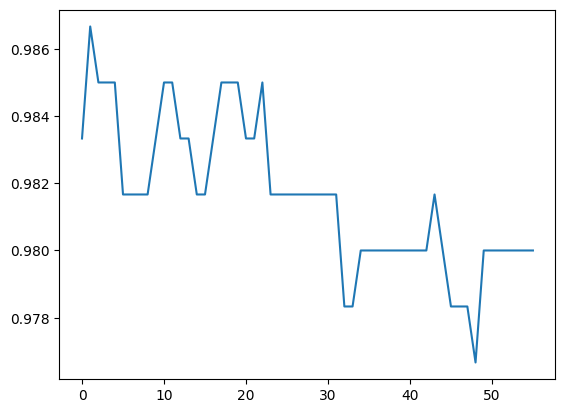

In [49]:
plt.plot(accuracies)